In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys

import hydroeval as he
import h5py
import pynhd as nhd
from matplotlib.colors import ListedColormap

sys.path.insert(0, '../')
from methods.processing import extract_loo_results_from_hdf5, get_upstream_gauges


from methods.plotting.diagnostic_plots import plot_grid_metric_map, plot_Nx3_error_slope_cdf
from methods.plotting.diagnostic_plots import plot_error_cdf_subplot, plot_error_slope_subplot, plot_Nx1_binyear_boxplots
from methods.plotting.data_plots import plot_data_summary
from methods.utils.constants import cms_to_mgd, crs, cartesian_crs
from methods.diagnostics.metrics import error_metrics
from methods.processing.load import load_leave_one_out_datasets, load_gauge_matches, load_unmanaged_gauge_metadata


from methods.utils.directories import fig_dir
from methods.plotting.styles import model_colors, model_labels, metric_labels
from methods.plotting.styles import lower_bound_metric_scores, upper_bound_metric_scores, ideal_metric_scores
from methods.plotting.styles import ax_tick_label_fsize, ax_label_fsize, sup_title_fsize, legend_fsize
from methods.plotting.styles import fig_dpi

# Directories
from methods.utils.directories import pywrdrb_dir, path_to_nhm_data, path_to_nwm_data

# Comparison dates
start_date = '1983-10-01'
end_date = '2016-12-31'

K = 5
model_datasets = ['nhmv10', 'nwmv21', 'obs_pub_nhmv10', 'obs_pub_nwmv21', 'obs_pub_nhmv10_ensemble', 'obs_pub_nwmv21_ensemble']
single_datasets = ['nhmv10', 'nwmv21', 'obs_pub_nhmv10', 'obs_pub_nwmv21']
pub_datasets = ['obs_pub_nhmv10', 'obs_pub_nwmv21']
ensemble_datasets = ['obs_pub_nhmv10_ensemble', 'obs_pub_nwmv21_ensemble']
error_datasets = ['nhmv10', 'nwmv21', 
                  'obs_pub_nhmv10', 'obs_pub_nwmv21', 
                  'obs_pub_nhmv10_ensemble', 'obs_pub_nwmv21_ensemble'] 

model_colors = {
    'obs': 'black',
    'nhmv10' : '#925736', 
    'nwmv21' : '#385723',
    'obs_pub_nhmv10' : '#F27300',
    'obs_pub_nhmv10_ObsScaled': '#F27300', 
    'obs_pub_nhmv10_ensemble' : '#F9B572', 
    'obs_pub_nhmv10_ObsScaled_ensemble' : '#F9B572', 
    'obs_pub_nwmv21' : '#0174BE', 
    'obs_pub_nwmv21_ensemble': '#9CD2F6',
    'obs_pub_nwmv21_ObsScaled' : '#0174BE', 
    'obs_pub_nwmv21_ObsScaled_ensemble': '#9CD2F6'
    }


ImportError: cannot import name 'get_basin_catchment_area' from 'methods.processing.prep_loo' (c:\Users\tjame\Desktop\Research\DRB\Pywr-DRB\DRB-Historic-Reconstruction\notebooks\..\methods\processing\prep_loo.py)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import geopandas as gpd
import sys

sys.path.insert(0, '../')
from methods.processing.load import load_gauge_matches, load_leave_one_out_datasets
from methods.processing.load import load_unmanaged_gauge_metadata
from methods.processing.load import load_historic_datasets
from methods.processing import extract_loo_results_from_hdf5, get_upstream_gauges
from methods.processing.prep_loo import get_basin_catchment_area
from methods.diagnostics import get_error_summary

from methods.plotting.diagnostic_plots import plot_grid_metric_map, plot_Nx3_error_slope_cdf
from methods.plotting.diagnostic_plots import plot_error_cdf_subplot
from methods.plotting.diagnostic_plots import plot_Nx1_binyear_boxplots
from methods.plotting.data_plots import plot_data_summary
from methods.utils.constants import cms_to_mgd, crs
from methods.utils.lists import model_datasets, pub_model_datasets
from methods.diagnostics.metrics import error_metrics
from methods.generator.inflow_scaling_regression import plot_inflow_scaling_regression
from methods.utils.directories import pywrdrb_dir, path_to_nhm_data, path_to_nwm_data, fig_dir
from methods.utils.directories import data_dir, output_dir


plt.ioff()

error_datasets = ['nhmv10', 'nwmv21', 
                  'obs_pub_nhmv10', 'obs_pub_nwmv21', 
                  'obs_pub_nhmv10_ensemble', 'obs_pub_nwmv21_ensemble'] 

recalculate_error_metrics = False

#####################
### Load Data #######
#####################

# Comparison dates
start_date = '1983-10-01'
end_date = '2016-12-31'


### Spatial
drb_boundary = gpd.read_file(f'{pywrdrb_dir}DRB_spatial/DRB_shapefiles/drb_bnd_polygon.shp').to_crs(crs)
drb_mainstem = gpd.read_file(f'{pywrdrb_dir}DRB_spatial/DRB_shapefiles/delawareriver.shp').to_crs(crs)
prediction_locations = pd.read_csv(f'{data_dir}prediction_locations.csv', sep = ',', index_col=0)
prediction_locations = gpd.GeoDataFrame(prediction_locations, geometry=gpd.points_from_xy(prediction_locations.long, prediction_locations.lat))
    
## Streamflows
Q_observed = pd.read_csv(f'{data_dir}USGS/drb_historic_unmanaged_streamflow_cms.csv', index_col=0, parse_dates=True)
Q_loo_datasets = load_leave_one_out_datasets()
Q_reconstructions = load_historic_datasets(model_datasets)
unmanaged_gauge_meta = load_unmanaged_gauge_metadata()
gauge_matches = load_gauge_matches()

loo_sites = Q_loo_datasets['nhmv10'].columns.to_list()

print('Finding upstream gauges from LOO sites')
subcatchment_gauges = get_upstream_gauges(loo_sites, unmanaged_gauge_meta,
                                          simplify=True)

## Basin area geom
# Get catchment areas
# print('Getting catchment areas...')
# basin_areas = np.zeros(len(loo_sites))
# for i, site in enumerate(loo_sites):
#     basin_areas[i] = get_basin_catchment_area(feature_id=site,
#                                               feature_source='nwissite')
    
print(f'Ready to analyze {len(loo_sites)} LOO sites')


################
### Errors #####
################
### Get Error Metrics
if recalculate_error_metrics:
    error_summary_annual = get_error_summary(Q_loo_datasets, 
                                             error_datasets, 
                                         loo_sites, 
                                         by_year=True, 
                                         start_date='1945-01-01', end_date='2016-12-31')
    error_summary_annual.to_csv(f'{output_dir}LOO/loo_error_summary_annual.csv')
    
    error_summary = get_error_summary(Q_loo_datasets, 
                                      error_datasets, 
                                         loo_sites,  
                                         start_date='1945-01-01', end_date='2016-12-31')
    error_summary.to_csv(f'{output_dir}LOO/loo_error_summary.csv')

else:
    error_summary_annual = pd.read_csv(f'{output_dir}LOO/loo_error_summary_annual.csv', dtype={'site':str})
    error_summary = pd.read_csv(f'{output_dir}LOO/loo_error_summary.csv', dtype={'site':str})


################
### Main #######
################

### Diagnostic data summary
print('Making data summary plot...')
plot_data_summary(Q_observed, 
                       unmanaged_gauge_meta, 
                       loo_sites, 
                       prediction_locations, 
                       drb_boundary, 
                       sort_by='lat')

Loading all leave-one-out datasets...
24 leave-one-out sites identified.
Loading upstream gauges from file...
1 marginal sites identified. Summing upstream flows.
obs_pub_nhmv10 01423000 has no nans
obs_pub_nwmv21 01423000 has no nans
Loading obs...
Loading nhmv10...
Loading nwmv21...
Loading obs_pub_nhmv10_ObsScaled...
Loading obs_pub_nwmv21_ObsScaled...
Loading obs_pub_nhmv10_ObsScaled_ensemble...
Loading obs_pub_nwmv21_ObsScaled_ensemble...
Finding upstream gauges from LOO sites
Loading upstream gauges from file...
Ready to analyze 24 LOO sites
Making data summary plot...


c:\Users\tjame\Desktop\Research\DRB\Pywr-DRB\DRB-Historic-Reconstruction\notebooks\..\methods\plotting\data_plots.py:143: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()


In [ ]:

#################
### Load data ###
#################

### Spatial
drb_boundary = gpd.read_file(f'{pywrdrb_dir}DRB_spatial/DRB_shapefiles/drb_bnd_polygon.shp').to_crs(crs)
drb_mainstem = gpd.read_file(f'{pywrdrb_dir}DRB_spatial/DRB_shapefiles/delawareriver.shp').to_crs(crs)
prediction_locations = pd.read_csv(f'../data/prediction_locations.csv', sep = ',', index_col=0)
prediction_locations = gpd.GeoDataFrame(prediction_locations, geometry=gpd.points_from_xy(prediction_locations.long, prediction_locations.lat))
    
## Streamflows
Q_observed = pd.read_csv(f'../data/USGS/drb_historic_unmanaged_streamflow_cms.csv', index_col=0, parse_dates=True)
Q = load_leave_one_out_datasets()
unmanaged_gauge_meta = load_unmanaged_gauge_metadata()
gauge_matches = load_gauge_matches()

loo_sites = Q['nhmv10'].columns.to_list()

print('Finding upstream gauges from LOO sites')
subcatchment_gauges = get_upstream_gauges(loo_sites, 
                                          unmanaged_gauge_meta,
                                          filename='leave_one_out_upstream_gauges.json',
                                          simplify=True)

marginal_loo_sites = []
for s in subcatchment_gauges.keys():
    if len(subcatchment_gauges[s]) >= 1:
        marginal_loo_sites.append(s)
print(f'{len(marginal_loo_sites)} marginal LOO sites')

    
print(f'Ready to analyze {len(loo_sites)} LOO sites')

Loading all leave-one-out datasets...
24 leave-one-out sites identified.
Loading upstream gauges from file...
1 marginal sites identified. Summing upstream flows.
obs_pub_nhmv10 01423000 has no nans
obs_pub_nwmv21 01423000 has no nans
Finding upstream gauges from LOO sites
Loading upstream gauges from file...
1 marginal LOO sites
Ready to analyze 24 LOO sites


In [68]:
## Get error metrics
recalculate_error_metrics = False
if recalculate_error_metrics:
    error_summary = get_error_summary(Q, error_datasets, 
                                            loo_sites,  
                                            start_date='1945-01-01', end_date='2016-12-31')
    error_summary.to_csv('../outputs/LOO/loo_error_summary.csv')

    error_summary_annual = get_error_summary(Q, error_datasets, 
                                            loo_sites, 
                                            by_year=True, 
                                            start_date='1945-01-01', end_date='2016-12-31')
    error_summary_annual.to_csv('../outputs/LOO/loo_error_summary_annual.csv')
else:
    error_summary = pd.read_csv('../outputs/LOO/loo_error_summary.csv', 
                                dtype={'site':str})
    error_summary_annual = pd.read_csv('../outputs/LOO/loo_error_summary_annual.csv',
                                       dtype={'site':str})

error_summary = error_summary.loc[error_summary.site.isin(loo_sites)]

import pandas as pd
import numpy as np
import h5py 
import pynhd as nhd

from methods.generator.QPPQModel import StreamflowGenerator
from methods.generator.single_site_generator import generate_single_gauge_reconstruction
from methods.processing.hdf5 import export_ensemble_to_hdf5
from methods.processing import get_upstream_gauges
from methods.utils.constants import cms_to_mgd
from methods.utils.directories import data_dir

## Relevant paths
path_to_nhm_data = '../../NHM-Data-Retrieval/datasets/NHMv10/'

# Restrict to DRB or broader region
filter_drb = True
boundary = 'drb' if filter_drb else 'regional'


#################
### Load data ###
#################

## USGS 
# Flows: DateTime index with USGS-{station_id} column names
unmanaged_gauge_flows = pd.read_csv(f'{data_dir}/USGS/{boundary}_historic_unmanaged_streamflow_cms.csv', 
                                    sep = ',', 
                                    dtype = {'site_no':str}, 
                                    index_col=0, parse_dates=True)*cms_to_mgd

# Metadata: USGS site number, longitude, latitude, comid, etc.
unmanaged_gauge_meta = pd.read_csv(f'{data_dir}/USGS/{boundary}_unmanaged_usgs_metadata.csv', 
                                    sep = ',', 
                                    dtype = {'site_no':str})
unmanaged_gauge_meta.set_index('site_no', inplace=True)

# List of just station numbers
usgs_gauge_ids = [c.split('-')[1] for c in unmanaged_gauge_flows.columns]

## NHMv1.0
# Segment outflows
drb_nhm_segment_flows = pd.read_hdf(f'{path_to_nhm_data}/hdf/drb_seg_outflow_mgd.hdf5', key = 'df')
drb_nhm_segment_flows.index = pd.to_datetime(drb_nhm_segment_flows.index)
drb_nhm_segment_flows = drb_nhm_segment_flows.loc['1983-10-01':, :]

# NHM-Gauge matches
# Change column name from nhm_segment_id to comid  ## TODO: Fix this in the NHM-Data-Retrieval code
nhm_gauge_matches = pd.read_csv(f'{path_to_nhm_data}/meta/drb_nhm_gage_segment_ids.csv', sep = ',', 
                                dtype = {'gage_id':'string', 'nhm_segment_id':'string'})
nhm_gauge_matches['comid'] = nhm_gauge_matches['nhm_segment_id']
nhm_gauge_matches['site_no'] = nhm_gauge_matches['gage_id']

## NWMv2.1
# Streamflows
drb_nwm_segment_flows = pd.read_csv(f'{data_dir}/NWMv21/nwmv21_unmanaged_gauge_streamflow_daily_mgd.csv', 
                                    sep = ',', index_col=0, parse_dates=True)
drb_nwm_segment_flows= drb_nwm_segment_flows.loc['1983-10-01':, :]

# Metadata for matching sites
nwm_gauge_matches = pd.read_csv(f'{data_dir}/NWMv21/nwmv21_unmanaged_gauge_metadata.csv', 
                                sep = ',', dtype={'site_no':'string', 'comid':'string'})


########################
### Pre-process data ###
########################

# Find sites that are present in USGS, NHM, and NWM
loo_sites = []
for site in nwm_gauge_matches.site_no.values:
    if site in nhm_gauge_matches.site_no.values:
        if site in unmanaged_gauge_meta.index.values:
            loo_sites.append(site)



## use pynhd to identify upstream gauges for each model site
catchment_subcatchments = get_upstream_gauges(loo_sites,
                                                unmanaged_gauge_meta,
                                                simplify=True)
for s in loo_sites:
    if s not in error_summary.site.values:
        loo_sites.remove(s)

print(f'Loo sites: {len(loo_sites)}')

Loading upstream gauges from file...
Loo sites: 24


In [26]:
# Metadata for matching sites
nwm_gauge_matches = pd.read_csv(f'{data_dir}/NWMv21/nwmv21_unmanaged_gauge_metadata.csv', 
                                sep = ',', dtype={'site_no':'string', 'comid':'string'})


########################
### Pre-process data ###
########################

# Find sites that are present in USGS, NHM, and NWM
loo_sites = []
for site in nwm_gauge_matches.site_no.values:
    if site in nhm_gauge_matches.site_no.values:
        if site in unmanaged_gauge_meta.index.values:
            loo_sites.append(site)


for s in loo_sites:
    if s not in error_summary.site.values:
        loo_sites.remove(s)
        
len(loo_sites)

24

In [27]:


lower_bound_metric_scores = {'nse':-1, 'kge':-1, 'r':0.5, 'alpha':0, 'beta':0,
                       'log_nse':-1, 'log_kge':0, 'log_r':0.5, 'log_alpha':-1, 'log_beta':-1, 
                       'Q0.1pbias':-1, 'Q0.2pbias':-1, 'Q0.3pbias':-1, 
                       'AbsQ0.1pbias':0, 'AbsQ0.2pbias':0, 'AbsQ0.3pbias':0}
ax_tick_label_fsize = 14
ax_label_fsize = 16
legend_fsize = 12

def plot_error_slope_subplot(ax, model, metric, error_summary, sites,
                       plot_ensemble = False, 
                       maximize=True, 
                       scatter_alpha = 0.4):
    """
    Makes a scatter/slope-change plot for 1 error metric 
    for both pub and non-pub variants of a model on a subplot ax.
    """
    ## Specs

    scatter_pt_size = 120 
    line_alpha = 0.35 if not plot_ensemble else 0.15

    YMIN = lower_bound_metric_scores[metric]
    YMAX = upper_bound_metric_scores[metric]

    # cmap
    cmap = mpl.colormaps.get_cmap('coolwarm_r')
    VMIN = -0.5
    VMAX = 0.5
    
    # Pull data
    metric_error_summary = error_summary.loc[error_summary['metric']==metric, :].copy()
    model_errors = metric_error_summary.loc[metric_error_summary['model']==model, :].copy()
    model_errors = model_errors.loc[model_errors['site'].isin(sites), :].copy()
    
    pub_model_errors = metric_error_summary.loc[metric_error_summary['model']==f'obs_pub_{model}', :].copy()
    pub_model_errors = pub_model_errors.loc[pub_model_errors['site'].isin(sites), :].copy()
    pub_ensemble_model_errors = metric_error_summary.loc[metric_error_summary['model']==f'obs_pub_{model}_ensemble', :].copy()
    pub_ensemble_model_errors = pub_ensemble_model_errors.loc[pub_ensemble_model_errors['site'].isin(sites), :].copy()
    
    N = len(sites)
    
    # vertical line
    ax.vlines(x=[0, 1], ymin=YMIN, ymax=YMAX, color='grey', linestyle='--')

    scatter_jitter = False
    if scatter_jitter:
        xs = np.random.normal(loc=0, scale=0.02, size=N)
    else:
        xs = np.zeros(N)
    ax.scatter(xs, model_errors['value'], 
               color=model_colors[model], 
               label=f'{model_labels[model]} Site Error', 
               s=scatter_pt_size, zorder=5,
               linewidth=1, edgecolor=model_colors[model], 
               alpha = scatter_alpha)
    ax.scatter(-xs+1, pub_model_errors['value'], 
               color=model_colors[f'obs_pub_{model}'], 
               label=f'{model_labels[f"obs_pub_{model}"]} Site Error',
               s=scatter_pt_size, zorder=5, 
               linewidth=1, edgecolor=model_colors[f'obs_pub_{model}'],
               alpha = scatter_alpha)

    # lines
    for s in sites:
        mod_site_error = model_errors.loc[model_errors['site']==s, 'value'].values[0]
        
        pub_mod_site_error = pub_model_errors.loc[pub_model_errors['site']==s, 'value'].values[0]

        c = 'grey'  # cmap(norm_slope)
        ax.plot([0, 1], [mod_site_error, pub_mod_site_error], 
                color=c, alpha=line_alpha, lw=2, zorder = 4)
        
        plot_ensemble_range = False
        c = 'grey'   #cmap(norm_slope)
        if plot_ensemble:
            if plot_ensemble_range:
                site_ensemble_max = pub_ensemble_model_errors.loc[pub_ensemble_model_errors['site']==s, 'value'].max()
                site_ensemble_min = pub_ensemble_model_errors.loc[pub_ensemble_model_errors['site']==s, 'value'].min()
                ax.fill_between([0, 1], 
                                [mod_site_error, site_ensemble_min], 
                                [mod_site_error, site_ensemble_max], 
                                color=c, alpha=0.1, zorder=0)
            else:
                for real in pub_ensemble_model_errors['realization'].unique():
                    pub_mod_site_error = pub_ensemble_model_errors.loc[(pub_ensemble_model_errors['site']==s) & 
                                                                        (pub_ensemble_model_errors['realization']==real), 
                                                                        'value'].values[0]
                    
                    ax.plot([0, 1], [mod_site_error, pub_mod_site_error], 
                            color=c, alpha=line_alpha, lw=0.5, 
                            zorder=0)
 
    ax.set_ylim(YMIN, YMAX)
    ax.set_xlim(-0.2, 1.2)
    
    # Convert x ticks to model labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels([])
    
    # Reduce yticks to only 0 and 1
    yticks = np.linspace(YMIN, YMAX, 3)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{y:.2f}' for y in yticks], 
                       fontsize= ax_tick_label_fsize)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=1)
    
    if not maximize:
        ax.invert_yaxis()
    
    ax.tick_params(axis='both', which='both', length=4, width=1, color='k')
    return ax



def plot_error_cdf_subplot(ax, models, metric, error_summary, 
                   axis_labels = True, legend=False, maximize=True, 
                   plot_median=True, plot_ensemble_range=False):
    """
    Makes a CDF plot of the error metric for each model on a subplot ax.
    """
    YMIN= lower_bound_metric_scores[metric]
    YMAX= upper_bound_metric_scores[metric]
    
    # Pull all data for different models
    data = {}
    for model in models:
        mod_data = error_summary.loc[error_summary['model'] == model, :]
        mod_metric_data = mod_data.loc[mod_data['metric'] == metric, :]
        
        if 'ensemble' in model:
            for real in mod_metric_data['realization'].unique():
                data[f'{model}_{real}'] = mod_metric_data.loc[mod_metric_data['realization']==real, 'value'].values
             
        else:
            data[model] = mod_metric_data['value'].values
    
    # Arrange data in rank order
    data_rank = {}
    for m in data.keys():
        if maximize:
            data_rank[m] = np.sort(data[m])
        else:
            data_rank[m] = np.sort(data[m])[::-1]
        
    # Plot CDF
    for model in models:
        if 'ensemble' in model:
            # Get range of realization values
            realizations = [int(m.split('_')[-1]) for m in data_rank.keys() if model in m]
            
            ensemble_ranks = np.zeros((len(realizations), len(data_rank[f'{model}_0'])))
            for i, real in enumerate(realizations):
                ensemble_ranks[i, :] = data_rank[f'{model}_{real}']
            
            
            if plot_ensemble_range:
                ensemble_min = np.min(ensemble_ranks, axis=0)
                ensemble_max = np.max(ensemble_ranks, axis=0)
                ax.fill_between(np.linspace(0, 1, len(data_rank[f'{model}_0'])), 
                                ensemble_min, ensemble_max, 
                                color=model_colors[model], 
                                alpha=0.8, zorder=2,
                                label=model_labels[model])
            else:
                # Combine all ranks across ensemble
                data_rank[model] = np.sort(ensemble_ranks.flatten())
                
                
                model_ls = '--' if model in ['nhmv10', 'nwmv21'] else '-'
                # ax.plot(np.linspace(0, 1, len(data_rank[model])), data_rank[model],    
                #         color=model_colors[model], 
                #         label=f'{model_labels[model]} Empirical CDF',
                #         ls = model_ls,
                #         lw=3, zorder=3)
        else:
            model_ls = '-'
            ax.plot(np.linspace(0, 1, len(data_rank[model])), data_rank[model],    
                    color=model_colors[model], 
                    label=f'{model_labels[model]} Empirical CDF',
                    ls = model_ls,
                    lw=3, zorder=3)
        if plot_median:
            if 'ensemble' not in model:
                
                median_value= np.median(data_rank[model])
                ax.scatter(0.5, median_value, color=model_colors[model], 
                           edgecolor='black', linewidth=1,
                           marker="^", s=100, zorder = 5,
                           label = f'{model_labels[model]} Median Error')                
    if legend:
        ax.legend()
    if axis_labels:
        ax.set_ylabel(metric_labels[metric], fontsize=ax_label_fsize)
        ax.set_xlabel('Non-Exceedance Prob.', fontsize=ax_label_fsize)

    ax.set_ylim(YMIN, YMAX)
    if not maximize:
        ax.invert_yaxis()
        
    # ax.set_yticklabels([lower_bound_metric_scores[metric], upper_bound_metric_scores[metric]])
    yticks = np.linspace(YMIN, YMAX, 3)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{y:.2f}' for y in yticks], 
                       fontsize= ax_tick_label_fsize)
    xticks = np.linspace(0, 1, 3)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'{x*100:.0f}%' for x in xticks], fontsize=ax_tick_label_fsize)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=1, alpha=1)
    ax.vlines(x=0.5, ymin=YMIN, ymax=YMAX, color='grey', lw=1, linestyle='--', alpha=0.3)

    # add tick marks 
    ax.tick_params(axis='both', which='both', length=4, width=1)
    
    return ax



def plot_Nx3_error_slope_cdf(error_summary, models, metrics, sites,
                             plot_ensemble=False, fig_dir = fig_dir,
                             save_fig=False):
    
    fig, axs = plt.subplots(nrows=len(metrics), ncols= 3, 
                            sharex='col', sharey='row',
                            dpi=200,
                            figsize = (3*3, len(metrics)*3))

    for i,m in enumerate(metrics):
        
        is_max = False if 'Q' in m else True
        
        axs[i,0] = plot_error_slope_subplot(axs[i,0], 'nhmv10', m, error_summary, sites=sites, 
                                    plot_ensemble=plot_ensemble,
                                    scatter_alpha=0.25,
                                    maximize=is_max)
        axs[i,1] = plot_error_slope_subplot(axs[i,1], 'nwmv21', m, error_summary, sites=sites,
                                    plot_ensemble = plot_ensemble,
                                    scatter_alpha=0.25, 
                                    maximize=is_max)
        
        axs[i, 2] = plot_error_cdf_subplot(axs[i, 2], models, m, error_summary, 
                                           legend=False, 
                                           axis_labels=False, 
                                           maximize=is_max, plot_median=True, 
                                           plot_ensemble_range=False)
        axs[i,0].set_ylabel(metric_labels[m], fontsize=ax_label_fsize)

    axs[-1, 0].set_xticklabels(['NHMv1.0', 'PUB-NHM'], fontsize=ax_tick_label_fsize)
    axs[-1, 1].set_xticklabels(['NWMv2.1', 'PUB-NWM'], fontsize=ax_tick_label_fsize)
    axs[-1, 0].set_xlabel('Model', fontsize=ax_label_fsize)
    axs[-1, 1].set_xlabel('Model', fontsize=ax_label_fsize)
    axs[-1, 2].set_xlabel('Non-Exceedance Prob.', fontsize=ax_label_fsize)
    # axs[-1, 2].set_xticklabels(['0%', '100%'], fontsize=ax_label_fsize)

    # make a single shared legend below the plots using only unique elements from each subplot
    handles = []
    labels = []
    for ax in axs.flat:
        h,l = ax.get_legend_handles_labels()
        for handle, label in zip(h,l):
            if label not in labels:
                # Reverse search model_labels
                model = [k for k,v in model_labels.items() if v==label.split(' ')[0]][0]
                if ('Empirical CDF' in label) or ('Median Error' in label):
                    c = handle.get_color() if 'Empirical CDF' in label else handle.get_facecolor()
                    model_ls = '--' if model in ['nhmv10', 'nwmv21'] else '-'
                    modified_handle = mpl.lines.Line2D([], [], 
                                                       color=c, 
                                                       marker='^', 
                                                       markeredgecolor='black',
                                                       markersize=10,
                                                       linestyle=model_ls)
                    modified_label = f'{label.split(" ")[0]} Error CDF & Median'
                    handle= modified_handle
                    label = modified_label
                else:
                    # Change alpha of scatter points to 1
                    # handle.set_alpha(0.85)
                    pass
                    
                handles.append(handle)
                labels.append(label)
    
    # Keep only unique handles and labels
    handles, labels = np.array(handles), np.array(labels)
    _, idx = np.unique(labels, return_index=True)
    handles, labels = handles[idx], labels[idx]
    
    ordered_labels = [
        f'{model_labels["nhmv10"]} Site Error',
        f'{model_labels["obs_pub_nhmv10"]} Site Error',
        f'{model_labels["nwmv21"]} Site Error',
        f'{model_labels["obs_pub_nwmv21"]} Site Error',
        f'{model_labels["nhmv10"]} Error CDF & Median',
        f'{model_labels["nwmv21"]} Error CDF & Median',
        f'{model_labels["obs_pub_nhmv10"]} Error CDF & Median',
        f'{model_labels["obs_pub_nwmv21"]} Error CDF & Median'        
    ]
    handles = handles[[np.where(labels==l)[0][0] for l in ordered_labels]]
    
    scatter_legend = fig.legend(handles[0:4], ordered_labels[0:4], 
                                loc='upper center', ncol=2, fontsize=legend_fsize, 
                                facecolor='white', framealpha=0.0,
                                columnspacing=4,
                                bbox_to_anchor=[0.35, -0.01])
    fig.add_artist(scatter_legend)
    
    cdf_legend = fig.legend(handles[4:], ordered_labels[4:], loc='upper center',
                            ncol=1, fontsize=legend_fsize, 
                            facecolor='white', framealpha=0.0,
                            bbox_to_anchor=[0.85, -0.01])
    
    fig.add_artist(cdf_legend)
        
    # plt.suptitle('Difference in metric performance between\nNHM/NWM and corresponding PUB-based predictions', fontsize=14, y=0.95)
    plt.tight_layout()
    fig.align_ylabels(axs[:, 0])
    # Save
    if save_fig:
        plt.savefig(f'{fig_dir}/svg/Nx3_LeaveOneOut_ErrorSlopeCDF.svg', 
                    dpi=200, bbox_inches='tight')
        plt.savefig(f'{fig_dir}/diagnostics/Nx3_LeaveOneOut_ErrorSlopeCDF.png', 
                    dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()
    return


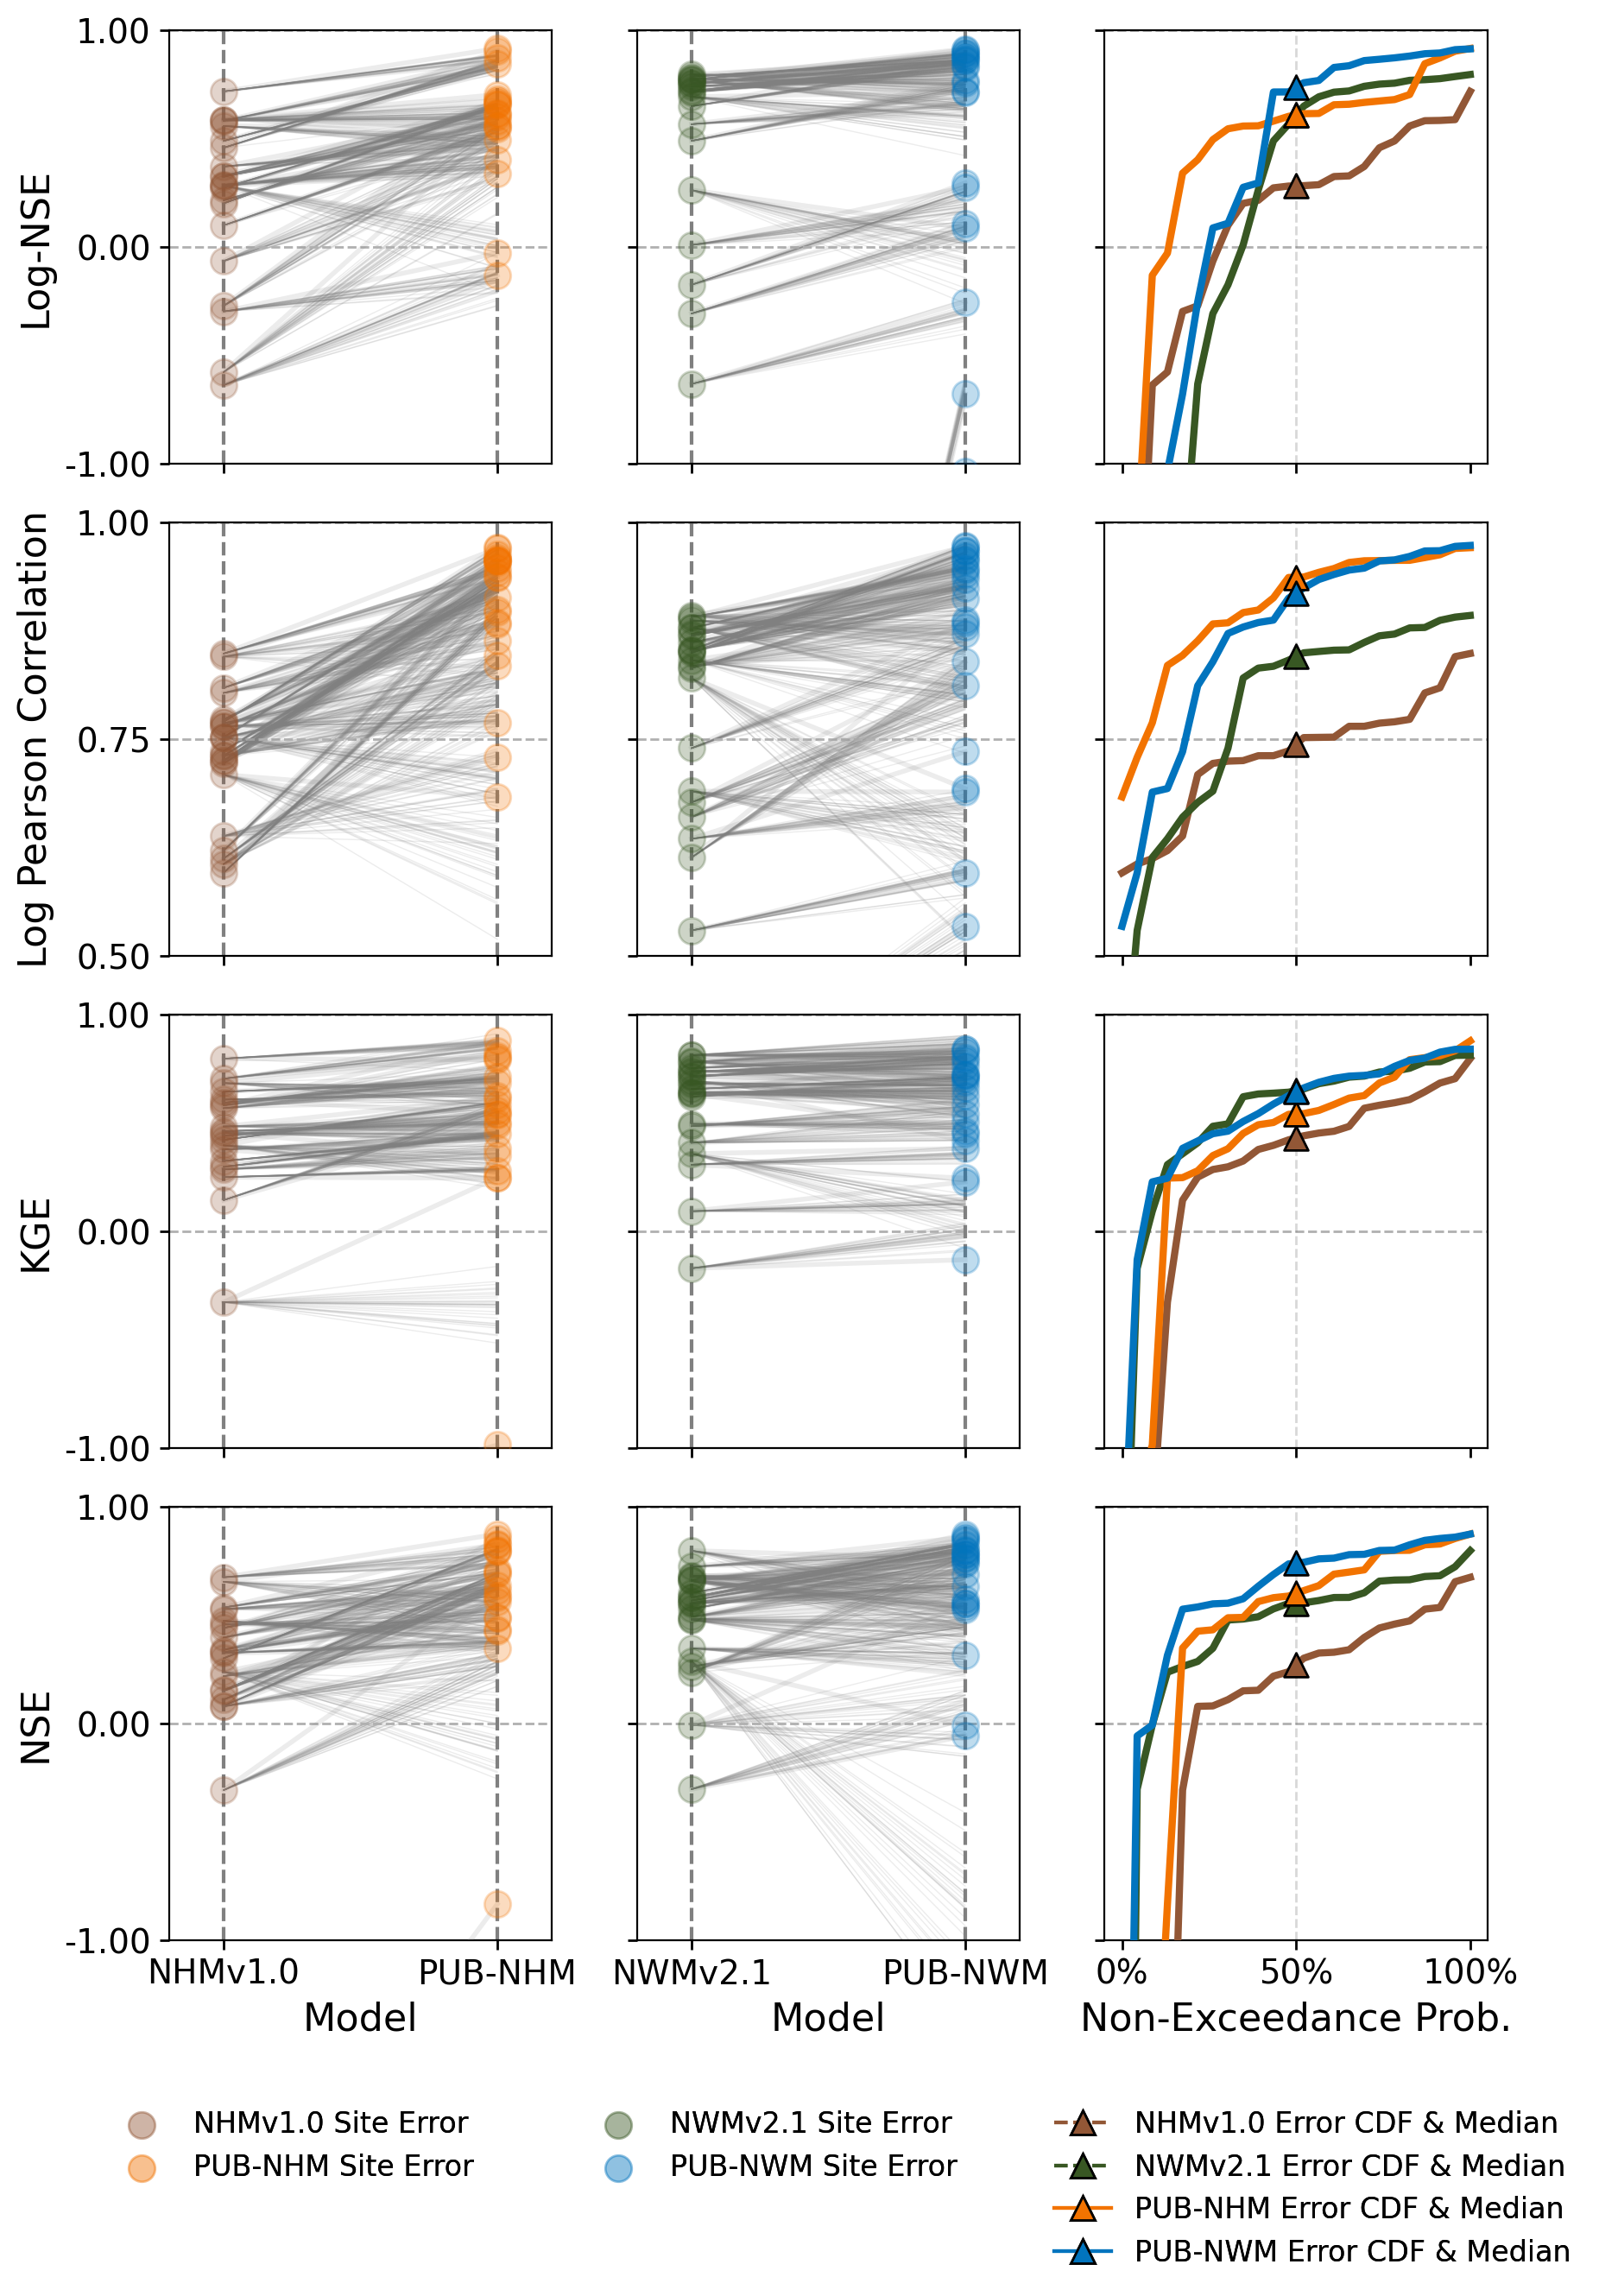

In [100]:
use_metrics = ['log_nse', 'log_r', 'kge', 'nse']

lower_bound_metric_scores = {'nse':-1, 'kge':-1, 'r':0.5, 'alpha':0, 'beta':0,
                       'log_nse':-1, 'log_kge':0, 'log_r':0.5, 'log_alpha':-1, 'log_beta':-1, 
                       'Q0.1pbias':-1, 'Q0.2pbias':-1, 'Q0.3pbias':-1, 
                       'AbsQ0.1pbias':0, 'AbsQ0.2pbias':0, 'AbsQ0.3pbias':0}
# Metric labels
metric_labels = {'nse': 'NSE', 'kge': 'KGE', 'r': 'Pearson Correlation', 'alpha': 'Alpha', 'beta': 'Beta',
                 'log_nse': 'Log-NSE', 'log_kge': 'Log-KGE', 'log_r': 'Log Pearson Correlation', 
                 'log_alpha': 'Log-Alpha', 'log_beta': 'Log-Beta', 
                 'Q0.1pbias': '0.1% Bias', 'Q0.2pbias': '0.2% Bias', 'Q0.3pbias': '0.3% Bias', 
                 'AbsQ0.1pbias': '0.1% Abs. Bias', 'AbsQ0.2pbias': '0.2% Abs. Bias', 
                 'AbsQ0.3pbias': '0.3% Abs. Bias'}

# plot_Nx3_error_slope_cdf(error_summary, 
#                          error_datasets[:-2], 
#                          use_metrics, marginal_loo_sites, 
#                          plot_ensemble=True)
# loo_sites = Q['nhmv10'].columns.to_list()
plot_Nx3_error_slope_cdf(error_summary, error_datasets, 
                         use_metrics, loo_sites, 
                         plot_ensemble=True)

In [66]:
error_summary.loc[error_summary['metric']=='log_beta', :].groupby('model')[['value']]

In [204]:
use_metrics = ['nse', 'kge', 'r', 'alpha', 'beta',
                'log_nse', 'log_kge', 'log_r', 'log_alpha', 'log_beta', 
                'AbsQ0.1pbias', 'AbsQ0.2pbias', 'AbsQ0.3pbias']

# get summaries of how frequently pub improves over non-pub
compare_stats = {}
for model in ['nhmv10', 'nwmv21']:
    

    for metric in use_metrics:
        scores = error_summary.loc[(error_summary['model']==model) & 
                                        (error_summary['metric']==metric), 
                                        :]
        scores.set_index('site', inplace=True)
        scores.loc[scores.index.isin(loo_sites), :]

        pub_scores = error_summary.loc[(error_summary['model']==f'obs_pub_{model}') & 
                                        (error_summary['metric']==metric), :]
        
        pub_scores.set_index('site', inplace=True)
        pub_scores = pub_scores.loc[pub_scores.index.isin(loo_sites), :]
        pub_scores = pub_scores.loc[scores.index, :] 

        nxm_diff = abs(scores['value']- ideal_metric_scores[metric])
        pub_diff = abs(pub_scores['value']- ideal_metric_scores[metric])

        improved = sum(pub_diff < nxm_diff)/len(pub_diff)
        
        compare_stats[f'pub_{model}_{metric}'] = improved


        improved = 0
        for r in error_summary.realization.unique():
            pub_scores = error_summary.loc[(error_summary['model']==f'obs_pub_{model}_ensemble') & 
                                            (error_summary['metric']==metric) & 
                                            (error_summary['realization']==r), :]
            
            pub_scores.set_index('site', inplace=True)
            pub_scores = pub_scores.loc[pub_scores.index.isin(loo_sites), :]
            pub_scores = pub_scores.loc[scores.index, :] 

            nxm_diff = abs(scores['value']- ideal_metric_scores[metric])
            pub_diff = abs(pub_scores['value']- ideal_metric_scores[metric])
            
            assert((pub_scores.index == scores.index).all()), 'Index mismatch'

            improved += sum(pub_diff < nxm_diff)/len(pub_diff)
        
        improved = improved/len(error_summary.realization.unique())
        compare_stats[f'pub_{model}_ensemble_{metric}'] = improved
        
        

        

In [250]:
# Get median correlation between pub and non-pub
error_summary.loc[error_summary['metric']=='log_r', :].groupby('model')[['value']].median()

value
model                            
nhmv10                   0.743798
nwmv21                   0.845001
obs_pub_nhmv10           0.936427
obs_pub_nhmv10_ensemble  0.893418
obs_pub_nwmv21           0.918153
obs_pub_nwmv21_ensemble  0.867694

In [254]:
use_metrics = ['nse', 'kge', 'r', 'alpha', 'beta',
                'log_nse', 'log_kge', 'log_r', 'log_alpha', 'log_beta', 
                'AbsQ0.1pbias', 'AbsQ0.2pbias', 'AbsQ0.3pbias']

# get summaries of how frequently pub improves over non-pub
compare_stats = {}
for model in ['nwmv21']:
    

    for metric in use_metrics:
        scores = error_summary.loc[(error_summary['model']==model) & 
                                        (error_summary['metric']==metric), 
                                        :]
        scores.set_index('site', inplace=True)
        scores.loc[scores.index.isin(loo_sites), :]

        pub_scores = error_summary.loc[(error_summary['model']==f'obs_pub_{model}') & 
                                        (error_summary['metric']==metric), :]
        
        pub_scores.set_index('site', inplace=True)
        pub_scores = pub_scores.loc[pub_scores.index.isin(loo_sites), :]
        pub_median = pub_scores[['value']].median()
        
        # repeat for ensemble
        pub_scores = error_summary.loc[(error_summary['model']==f'obs_pub_{model}_ensemble') & 
                                        (error_summary['metric']==metric), :]
        pub_scores.set_index('site', inplace=True)
        pub_scores = pub_scores.loc[pub_scores.index.isin(loo_sites), :]
        pub_median_ensemble = pub_scores[['value']].median()
        
        nxm_median = scores[['value']].median()
        nxm_diff = abs(nxm_median- ideal_metric_scores[metric])
        pub_diff = abs(pub_median- ideal_metric_scores[metric])
        pub_ensemble_diff = abs(pub_median_ensemble- ideal_metric_scores[metric])
        
        # compare_stats[f'pub_{model}_{metric}'] = (pub_diff < nxm_diff).values[0]
        compare_stats[f'pub_{model}_ensemble_{metric}'] = (pub_ensemble_diff < nxm_diff).values[0]
compare_stats = pd.Series(compare_stats)

print(f'{compare_stats.sum()} out of {len(use_metrics)} metrics show improvement of PUB over non-PUB')

compare_stats

9 out of 13 metrics show improvement of PUB over non-PUB


pub_nwmv21_ensemble_nse              True
pub_nwmv21_ensemble_kge              True
pub_nwmv21_ensemble_r                True
pub_nwmv21_ensemble_alpha            True
pub_nwmv21_ensemble_beta             True
pub_nwmv21_ensemble_log_nse          True
pub_nwmv21_ensemble_log_kge         False
pub_nwmv21_ensemble_log_r            True
pub_nwmv21_ensemble_log_alpha       False
pub_nwmv21_ensemble_log_beta        False
pub_nwmv21_ensemble_AbsQ0.1pbias     True
pub_nwmv21_ensemble_AbsQ0.2pbias     True
pub_nwmv21_ensemble_AbsQ0.3pbias    False
dtype: bool

C:\Users\tjame\AppData\Local\Temp\ipykernel_6380\1965026789.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


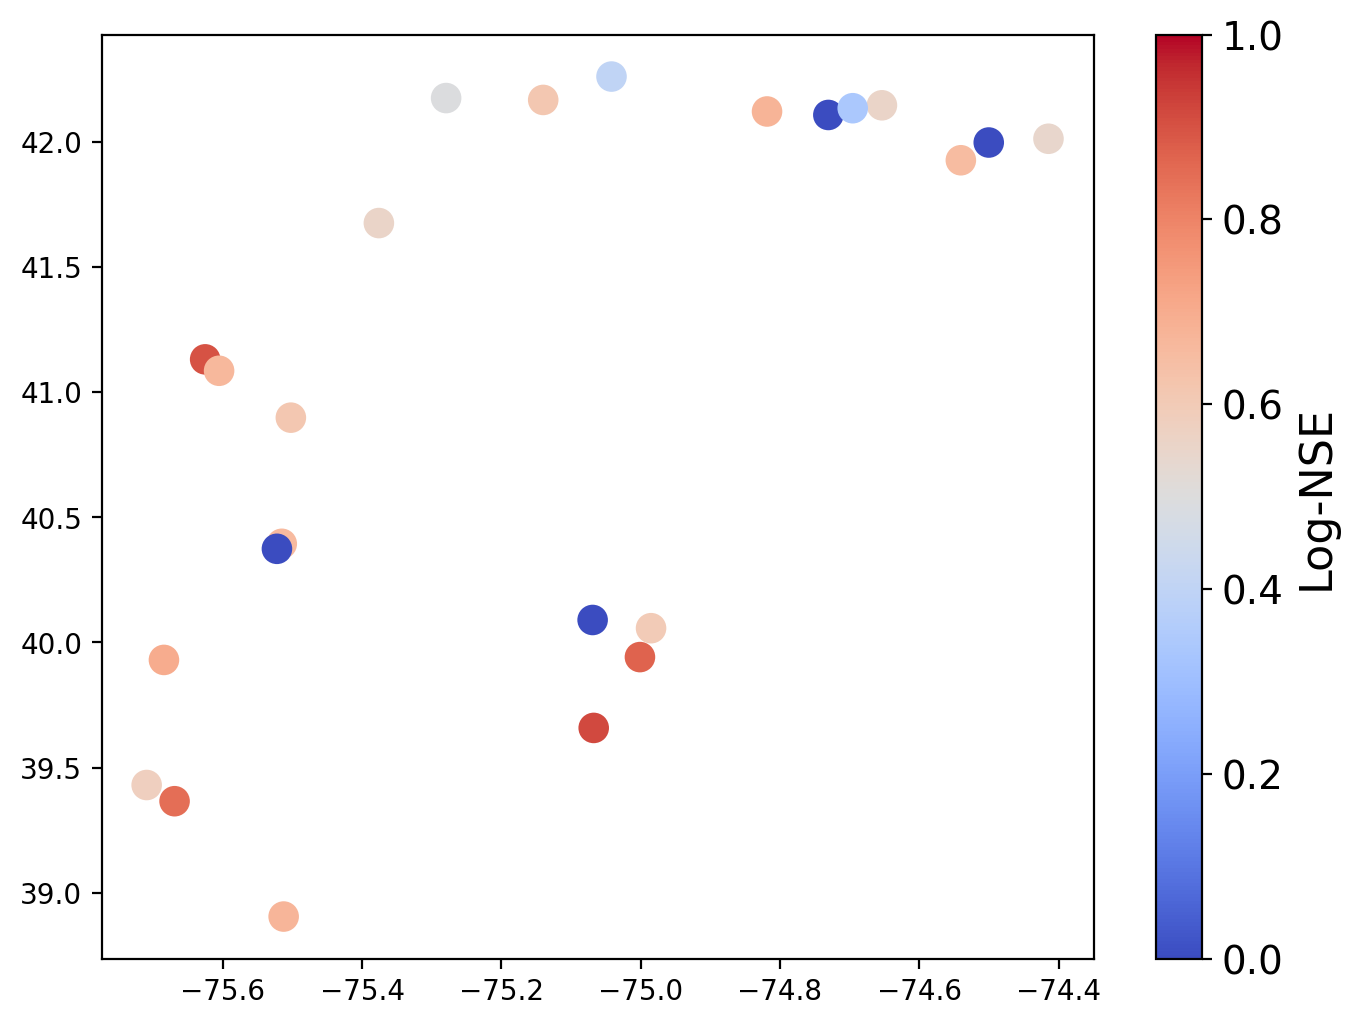

In [245]:
# Plot site scatter (lat, lon) and error metric as color
fig, ax = plt.subplots(dpi=200, figsize=(8, 6))
color_metric = 'log_nse'
model = 'obs_pub_nhmv10'
cmap = mpl.cm.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=0, vmax=1)


colors= cmap(norm(error_summary.loc[(error_summary['model']==model) & 
                                   (error_summary['metric']==color_metric), 'value']))

ax.scatter(unmanaged_gauge_meta.loc[loo_sites, 'long'],
           unmanaged_gauge_meta.loc[loo_sites, 'lat'], 
           color=colors, s=100)

# Add colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(metric_labels[color_metric], fontsize=16)
cbar.ax.tick_params(labelsize=14)


In [219]:
compare_stats.sum()

9

ValueError: x and y must be the same size

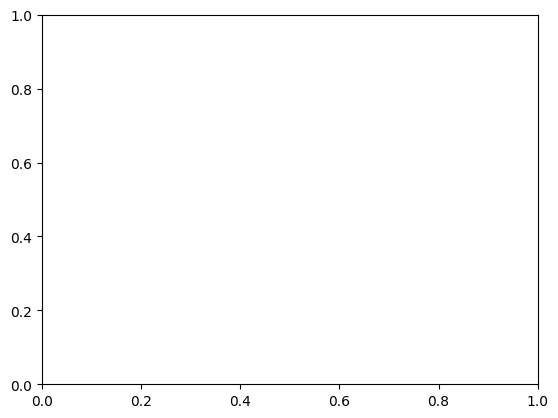

In [236]:
plt.scatter(pub_scores.value, scores.value)
plt.xlim(0, 1)
plt.ylim(0, 1)

#1:1 line
plt.plot([0, 1], [0, 1], color='black', linestyle='--')


<Axes: xlabel='value', ylabel='model'>

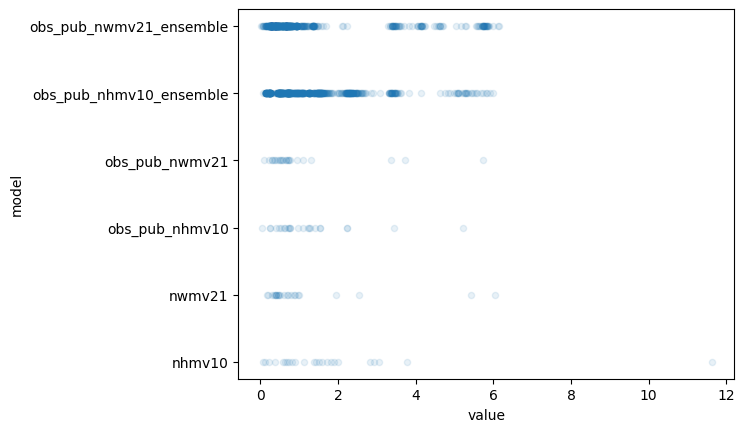

In [235]:
error_summary.loc[(error_summary['metric']=='AbsQ0.3pbias'), :].plot(x='value', y='model', kind='scatter', alpha=0.1)

<Axes: >

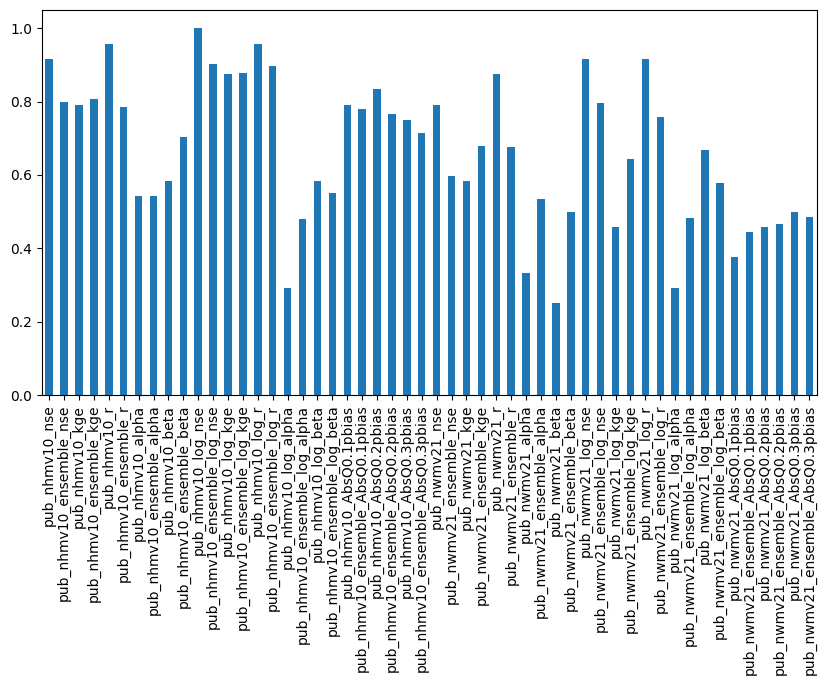

In [205]:
plt.figure(figsize=(10, 5))
pd.Series(compare_stats).plot(kind='bar')

In [161]:
ideal_metric_scores

{'nse': 1,
 'kge': 1,
 'r': 1,
 'alpha': 1,
 'beta': 1,
 'log_nse': 1,
 'log_kge': 1,
 'log_r': 1,
 'log_alpha': 1,
 'log_beta': 1,
 'Q0.1pbias': 0.0,
 'Q0.2pbias': 0.0,
 'Q0.3pbias': 0.0,
 'AbsQ0.1pbias': 0.0,
 'AbsQ0.2pbias': 0.0,
 'AbsQ0.3pbias': 0.0}

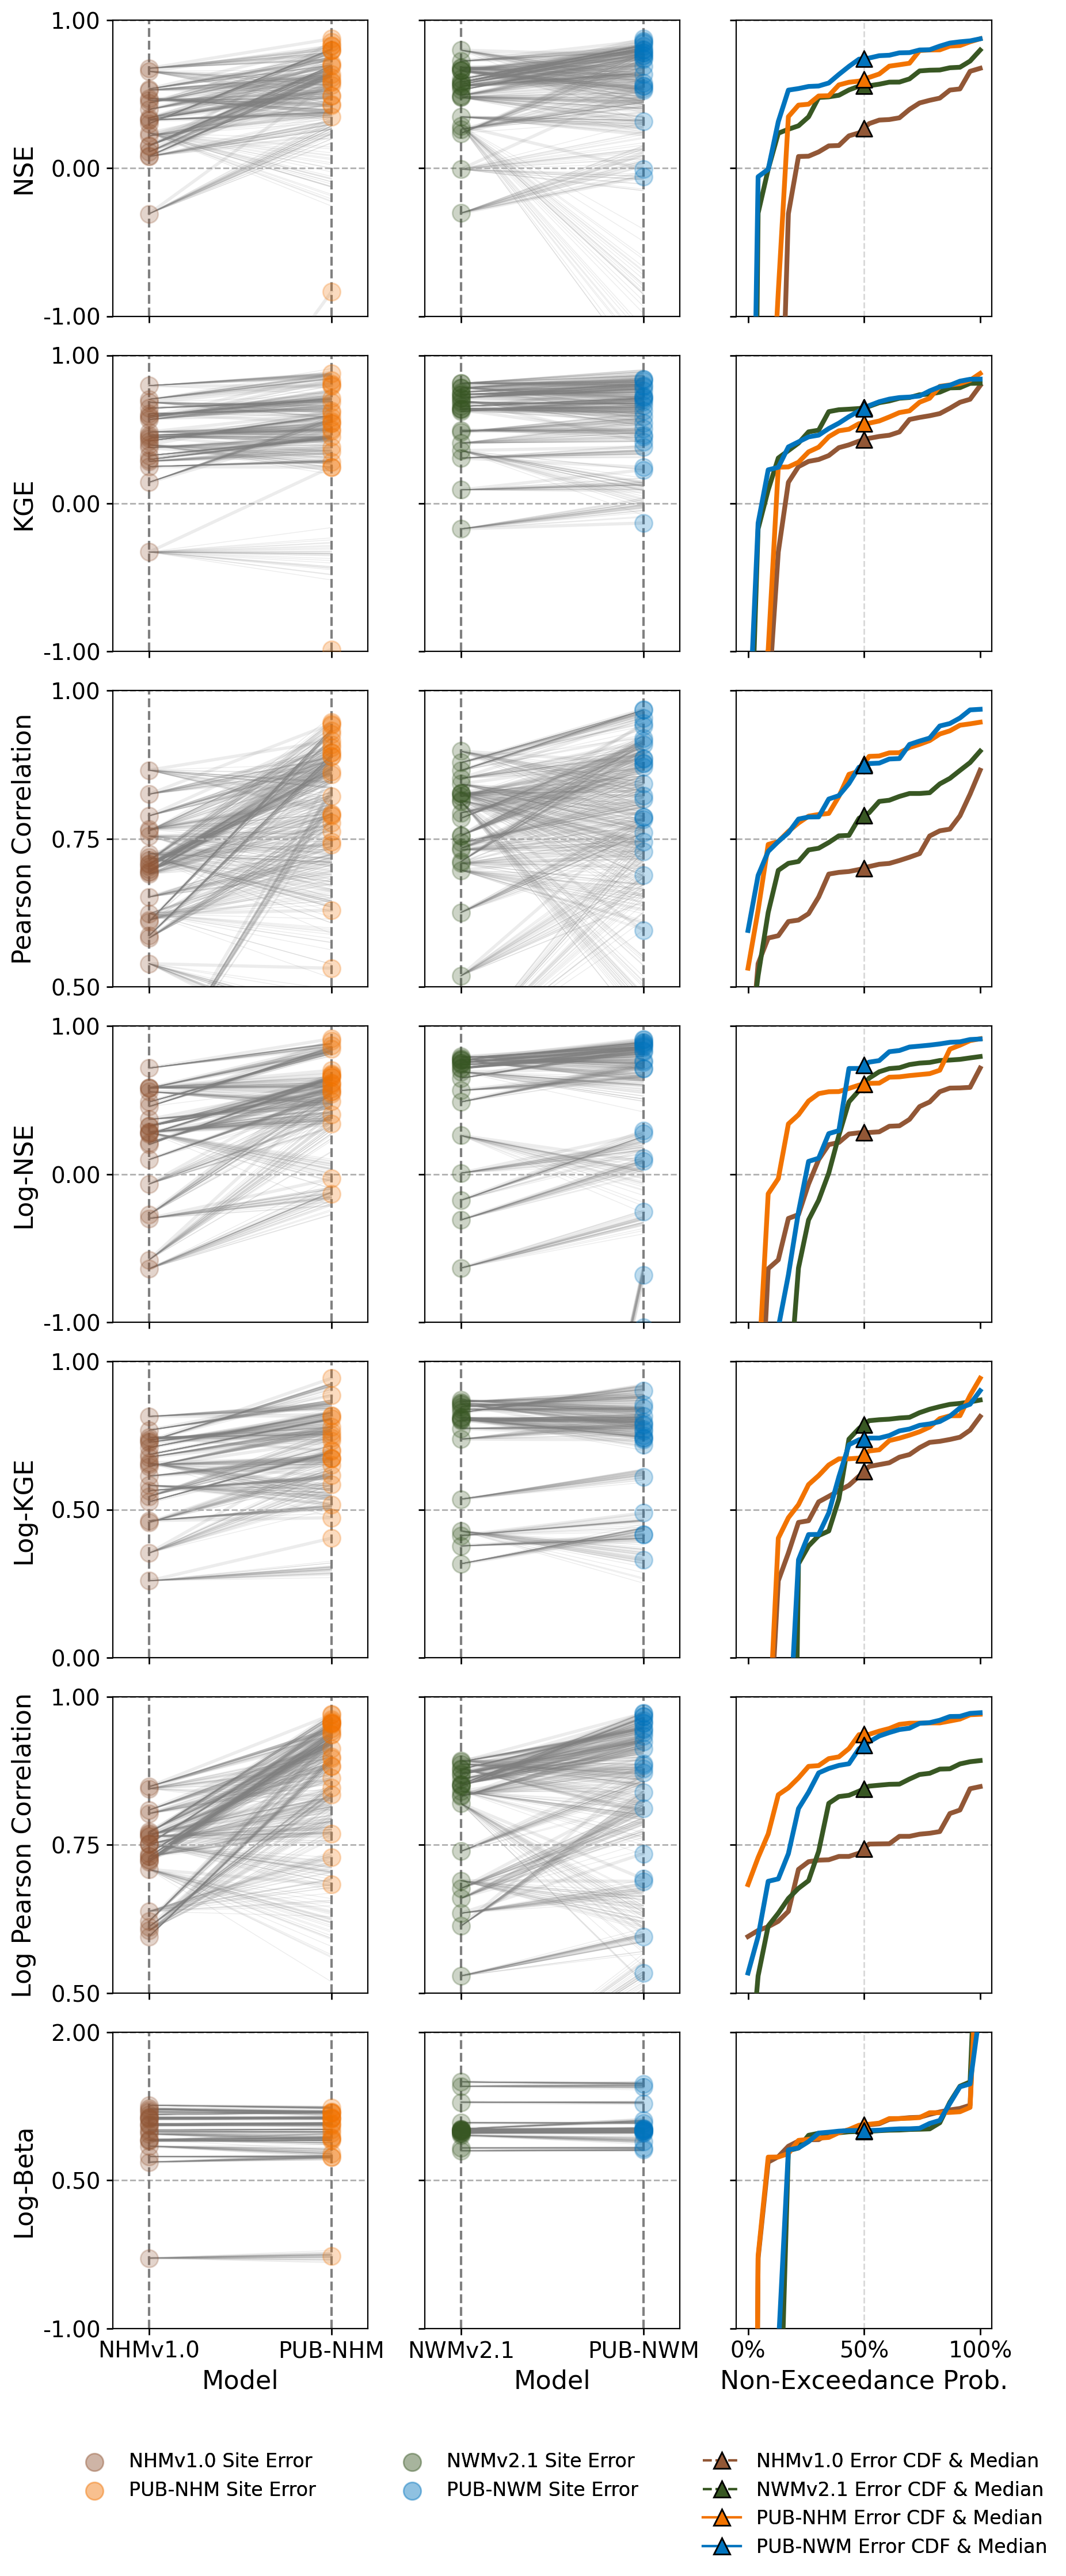

In [217]:
use_metrics = ['nse', 'kge', 'r', 
               'log_nse', 'log_kge', 'log_r', 
               'log_beta']


plot_Nx3_error_slope_cdf(error_summary, error_datasets, 
                         use_metrics, loo_sites, 
                         plot_ensemble=True)


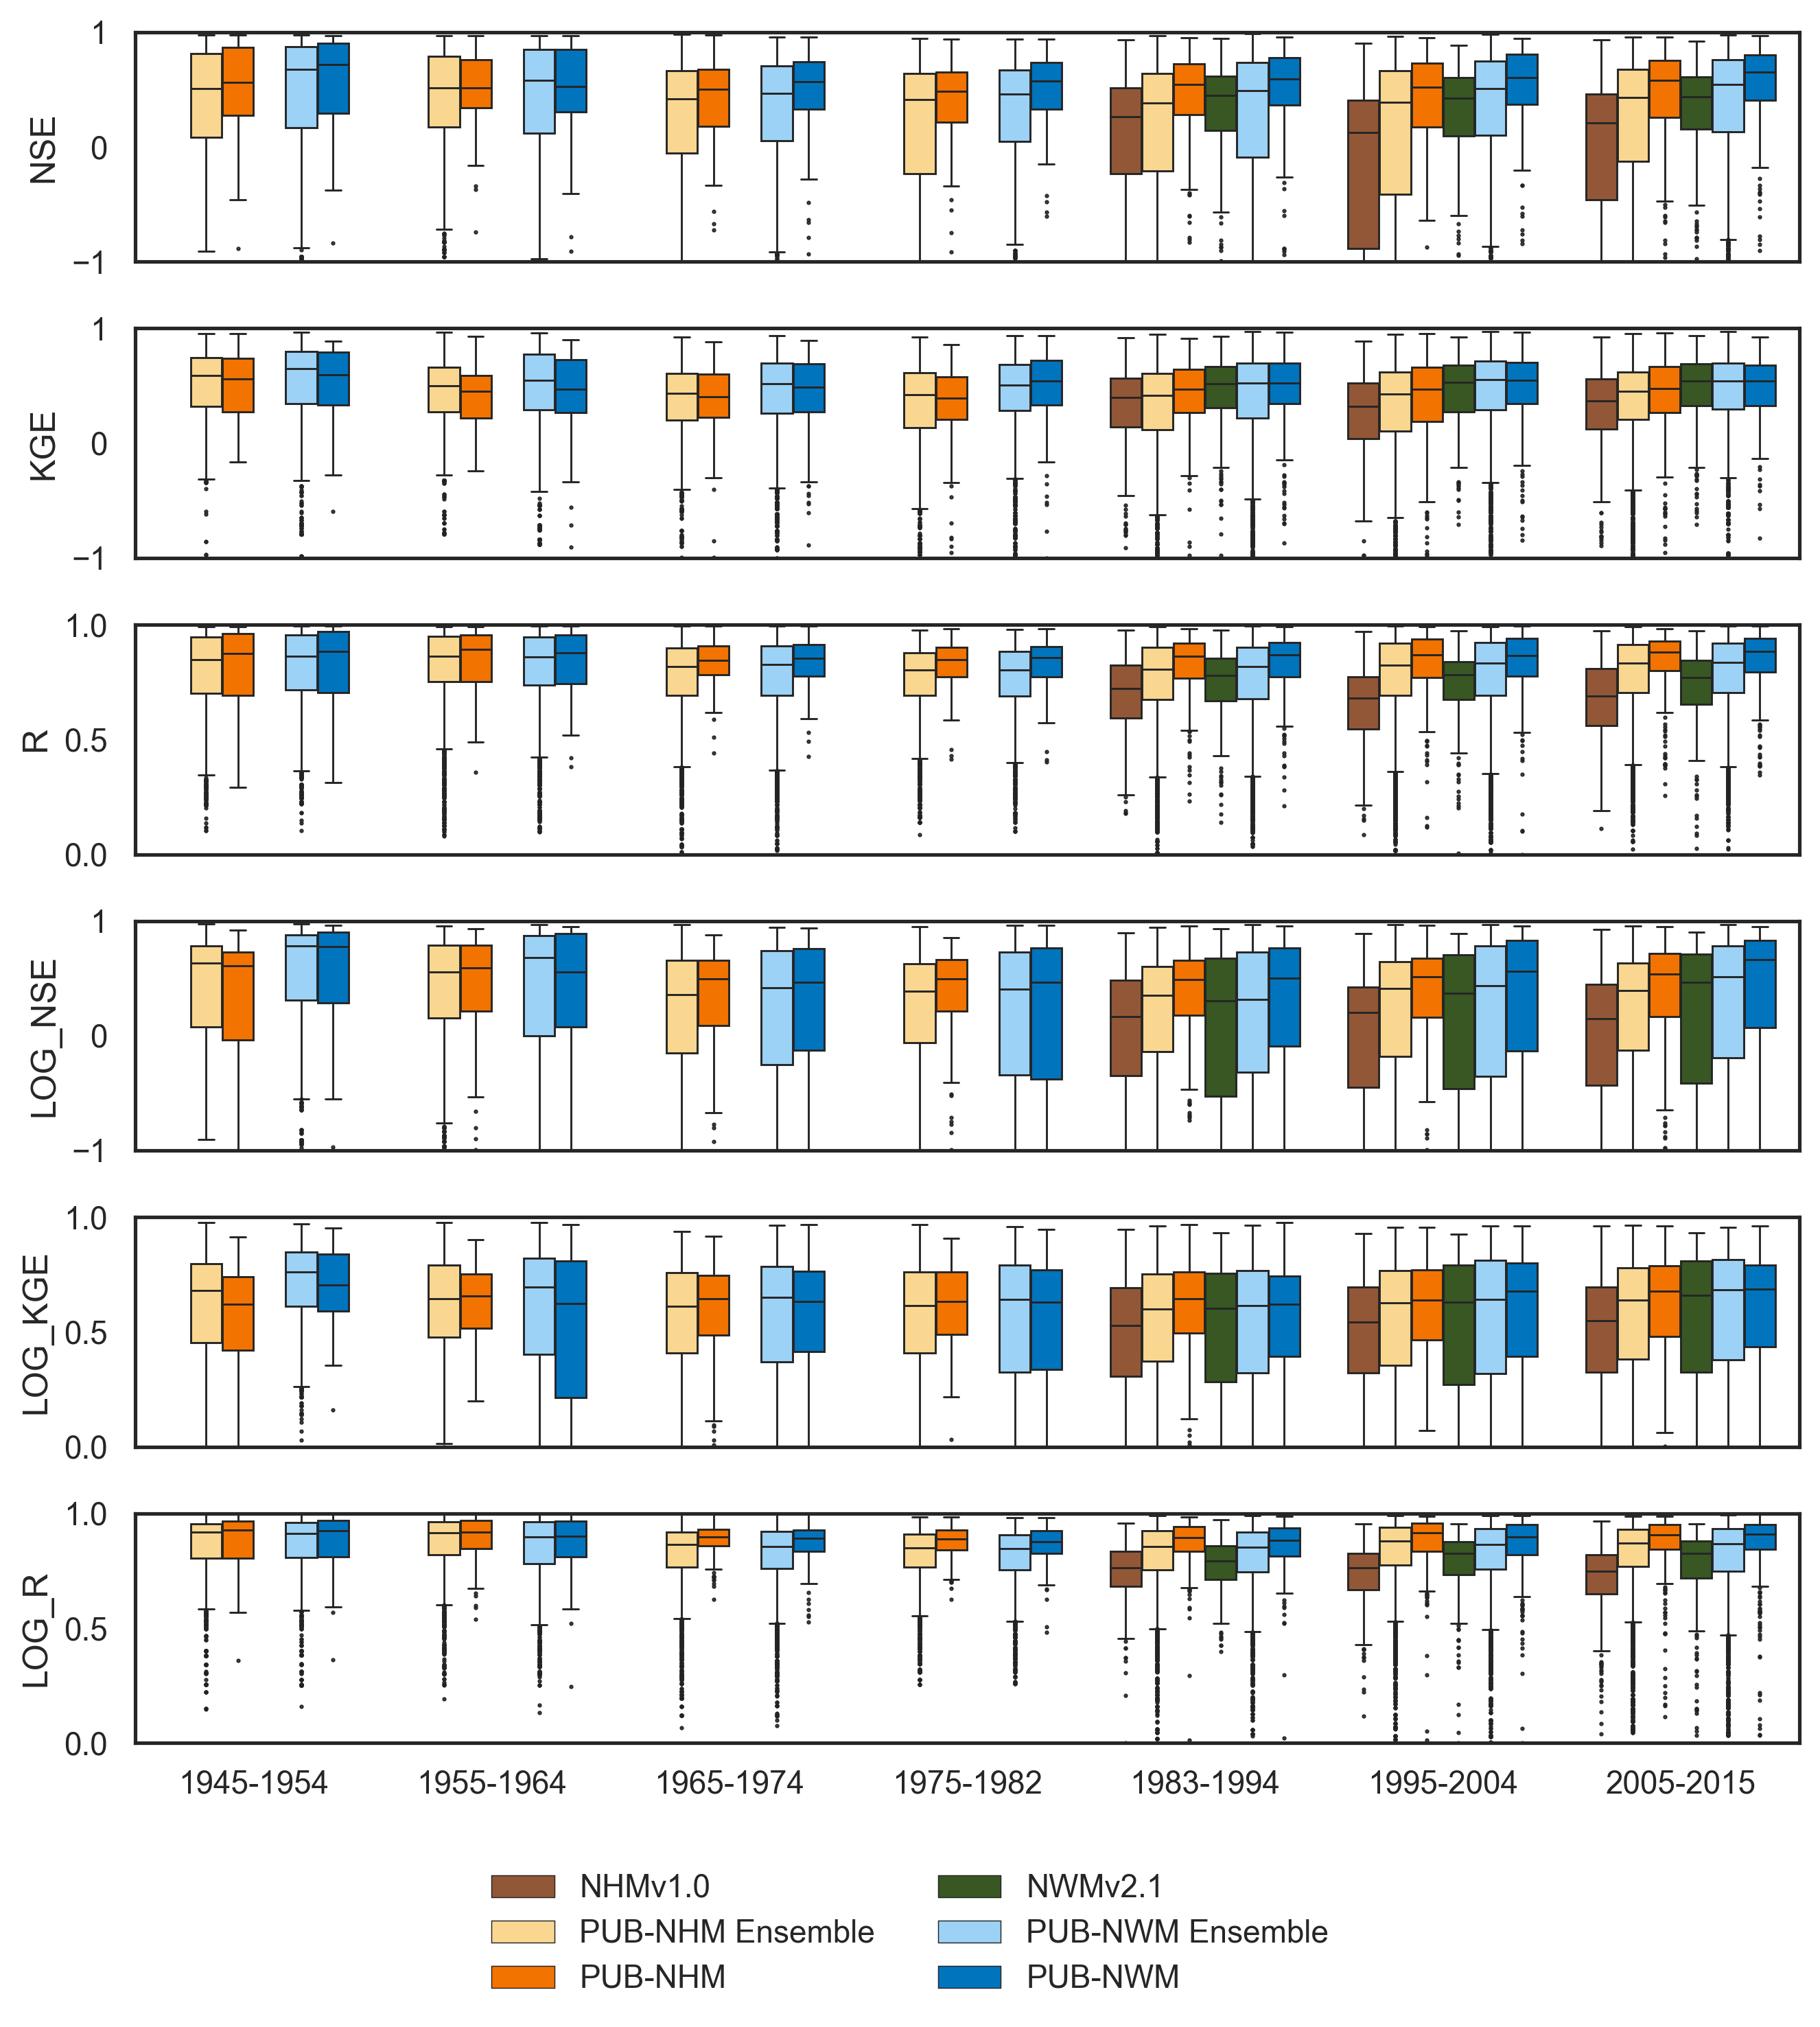

In [11]:
model_colors = {
    'obs': 'black',
    'nhmv10' : '#925736', 
    'nwmv21' : '#385723',
    'obs_pub_nhmv10' : '#F27300', 
    'obs_pub_nhmv10_ensemble' : '#FAD790', 
    'obs_pub_nwmv21' : '#0174BE', 
    'obs_pub_nwmv21_ensemble': '#9CD2F6'
    }

ideal_metric_scores = {'nse':1, 'kge':1, 'r':1, 'alpha':1, 'beta':1,
                       'log_nse':1, 'log_kge':1, 'log_r':1, 'log_alpha':1, 'log_beta':1, 
                       'Q0.1pbias':0.0, 'Q0.2pbias':0.0, 'Q0.3pbias':0.0, 
                       'AbsQ0.1pbias':0.0, 'AbsQ0.2pbias':0.0, 'AbsQ0.3pbias':0.0}
                
lower_bound_metric_scores = {'nse':-1, 'kge':-1, 'r':0.0, 'alpha':0, 'beta':0,
                       'log_nse':-1, 'log_kge':0, 'log_r':0.0, 'log_alpha':-1, 'log_beta':-1, 
                       'Q0.1pbias':-1, 'Q0.2pbias':-1, 'Q0.3pbias':-1, 
                       'AbsQ0.1pbias':0, 'AbsQ0.2pbias':0, 'AbsQ0.3pbias':0}

upper_bound_metric_scores = {'nse':1, 'kge':1, 'r':1, 'alpha':2, 'beta':2,
                       'log_nse':1, 'log_kge':1, 'log_r':1, 'log_alpha':2, 'log_beta':2, 
                       'Q0.1pbias':1, 'Q0.2pbias':1, 'Q0.3pbias':1, 
                       'AbsQ0.1pbias':3, 'AbsQ0.2pbias':3, 'AbsQ0.3pbias':3}

def group_metric_data_yearbin(error_summary_annual, bin_size, metric):
    # Filter the DataFrame for the 'nse' metric
    metric_data = error_summary_annual[error_summary_annual['metric'] == metric]
    metric_data = metric_data.dropna(subset=['value'])

    # Bin the years into N-year bins
    year_min, year_max = 1945, 2022  # Define your min and max years
    bins = range(year_min, year_max + bin_size, bin_size)  # Create bins
    labels = [f'{i}-{i + bin_size - 1}' for i in bins[:-1]]  # Create labels for bins
    
    bins = np.array([1945, 1955, 1965, 1975, 1983, 1995, 2005, 2016])
    labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]

    
    metric_data['year_bin'] = pd.cut(metric_data['year'], bins=bins, labels=labels, right=False)

    # Ensure the 'value' column is numeric
    metric_data['value'] = pd.to_numeric(metric_data['value'], errors='coerce')

    # Drop NaNs that were coerced during the numeric conversion
    metric_data.dropna(subset=['value'], inplace=True)
    
    return metric_data


def plot_binyear_boxplot_subplot(error_summary_annual, 
                                 ax, model_colors, 
                                 metric='nse', bin_size=10,
                                 plot_ensembles= False,
                                 ideal_metric_scores=ideal_metric_scores,
                                 lower_bound_metric_scores=lower_bound_metric_scores, 
                                 upper_bound_metric_scores=upper_bound_metric_scores,
):
    """Make a seaborn box plot of errors by year bin and model
    """

    metric_data = group_metric_data_yearbin(error_summary_annual, 
                                                    bin_size=bin_size, metric=metric)
    
    
    if plot_ensembles:
        model_hue_order = ['nhmv10', 'obs_pub_nhmv10_ensemble', 'obs_pub_nhmv10',  
                           'nwmv21', 'obs_pub_nwmv21_ensemble', 'obs_pub_nwmv21']
    else:
        model_hue_order = ['nhmv10', 'obs_pub_nhmv10', 
                           'nwmv21', 'obs_pub_nwmv21']
    flierprops = dict(marker='o', markerfacecolor='k', markersize=0.5,
                    linestyle='none')
    
    sns.boxplot(y="value", x="year_bin", hue="model", 
                hue_order = model_hue_order,
                data=metric_data, 
                palette=model_colors,
                saturation=1,
                linewidth=0.7,
                flierprops = flierprops,
                ax=ax)

    # add horizontal line across full boxplot area
    ax.axhline(ideal_metric_scores[metric], 
               ls='-', color='black', linewidth=1, 
               alpha=0.5, 
               zorder=0)
    ax.set_ylabel(metric.upper())
    ax.set_xlabel('')

    ax.legend().set_visible(False)
    ax.set_ylim([lower_bound_metric_scores[metric],
                 upper_bound_metric_scores[metric]])
    # Turn off axis boarder box
    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)
    # ax.spines["bottom"].set_visible(False)
    
    # ax.grid(which='major', axis='y', linestyle='-', alpha=0.5)
    
    return ax




# Test
def plot_Nx1_binyear_boxplots(error_summary_annual, 
                              metrics, model_colors,
                              ideal_metric_scores=ideal_metric_scores,
                              lower_bound_metric_scores=lower_bound_metric_scores,
                              upper_bound_metric_scores=upper_bound_metric_scores,
                              bin_size=10, plot_ensembles= True):

    NROWS = len(metrics)
    # Set up the matplotlib figure and aesthetics
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    
    fig, axs = plt.subplots(nrows=NROWS, ncols=1, 
                            figsize=(9, (NROWS*1.5)), 
                            dpi = 300, sharex=True)
    for i, metric in enumerate(metrics):
        ax = axs[i]
        plot_binyear_boxplot_subplot(error_summary_annual, ax, model_colors,
                                    metric=metric, bin_size=bin_size,
                                    plot_ensembles=plot_ensembles)
    
    # Make a single legend for the whole plot
    handles, labels = ax.get_legend_handles_labels()
    # Fix labels
    labels = [model_labels[label] for label in labels]
    
    fig.legend(handles, labels, loc='lower center', ncol=2, 
               bbox_to_anchor=(0.5, -0.1), frameon=False)
    
    
    plt.tight_layout()
    plt.show()
    return 

use_metrics = ['nse', 'kge', 'r', 'log_nse', 
               'log_kge', 'log_r']

plot_Nx1_binyear_boxplots(error_summary_annual,
                          use_metrics, model_colors,
                            bin_size=10, plot_ensembles=True)


In [ ]:

# Make 2x3 grid of colors using matplotlib. 
# The top row is [nhmv10, obs_pub_nhmv10, obs_pub_nhmv10_ensemble]
# The bottom row is [nwmv21, obs_pub_nwmv21, obs_pub_nwmv21_ensemble]
# colors taken from model_colors dictionary
# testing palette

model_colors = {
    'obs': 'black',
    'nhmv10' : 'indigo', 
    'nwmv21' : 'darkmagenta',
    'obs_pub_nhmv10' : '#F39634', 
    'obs_pub_nhmv10_ensemble' : '#FAC083', 
    'obs_pub_nwmv21' : '#77C1F4', 
    'obs_pub_nwmv21_ensemble':'#1A72AF'
    }


sns.palplot(model_colors.values(), size=3)


model_colors = {
    'obs': 'black',
    'nhmv10' : 'indigo', 
    'nwmv21' : '#748E63',
    'obs_pub_nhmv10' : '#f28500', 
    'obs_pub_nhmv10_ensemble' : '#F9B572', 
    'obs_pub_nwmv21' : '#77C1F4', 
    'obs_pub_nwmv21_ensemble':'#1A72AF'
    }


sns.palplot(model_colors.values(), size=3)

model_colors = {
    'obs': 'black',
    'nhmv10' : '#6C3428', 
    'nwmv21' : '#186F65',
    'obs_pub_nhmv10' : '#E55604', 
    'obs_pub_nhmv10_ensemble' : '#F9B572', 
    'obs_pub_nwmv21' : '#77C1F4', 
    'obs_pub_nwmv21_ensemble':'#26577C'
    }


sns.palplot(model_colors.values(), size=3)

model_colors = {
    'obs': 'black',
    'nhmv10' : '#6C3428', 
    'nwmv21' : '#4C4B16',
    'obs_pub_nhmv10' : '#E55604', 
    'obs_pub_nhmv10_ensemble' : '#F9B572', 
    'obs_pub_nwmv21' : '#77C1F4', 
    'obs_pub_nwmv21_ensemble':'#26577C'
    }


sns.palplot(model_colors.values(), size=3)

model_colors = {
    'obs': 'black',
    'nhmv10' : '#6E4B1F', 
    'nwmv21' : '#5B8C5A',
    'obs_pub_nhmv10' : '#E55604', 
    'obs_pub_nhmv10_ensemble' : '#F9B572', 
    'obs_pub_nwmv21' : '#0174BE', 
    'obs_pub_nwmv21_ensemble': '#77C1F4'
    }
sns.palplot(model_colors.values(), size=3)
model_colors = {
    'obs': 'black',
    'nhmv10' : '#693F27', 
    'nwmv21' : '#004225',
    'obs_pub_nhmv10' : '#E55604', 
    'obs_pub_nhmv10_ensemble' : '#F2E394', 
    'obs_pub_nwmv21' : '#0174BE', 
    'obs_pub_nwmv21_ensemble': '#77C1F4'
    }
sns.palplot(model_colors.values(), size=3)

In [ ]:


fig, ax = plt.subplots(figsize=(18, 5))
sns.violinplot(data=error_summary,
               x='metric', y='value', hue='model', inner='box', 
               ax=ax,
               hue_order= ['nhmv10', 'obs_pub_nhmv10', 'obs_pub_nhmv10_ensemble', 'nwmv21', 'obs_pub_nwmv21', 'obs_pub_nwmv21_ensemble'],
               palette=model_colors, 
               linewidth=0.5,
               cut=1.0, bw=0.15, scale='width', alpha=0.5) 

# for i,model in enumerate(['nhmv10', 'obs_pub_nhmv10', 'nwmv21', 'obs_pub_nwmv21']):
#     plt.scatter(x=np.ones(len(loo_sites))*i*0.2-0.3, y=loo_summary[model].loc[:, metric], 
#                 s=75, alpha=0.2, color='k')

ax.hlines(1, -0.5, 10, color='k', linestyle='--', linewidth=2)
ax.set_ylim([2, 0])

In [16]:
marginal_loo_sites

['01463500', '01472810', '01447720', '01423000', '01422747', '01413500']

In [ ]:
1447680

In [ ]:
test_site = loo_sites[1]
n_bootstrap = 1000
x=7
N=10

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['obs_pub_nhmv10'].loc[start_date:end_date, test_site],x=x, N=N)
print(f'7Q10 for PUB-NHM is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['obs_pub_nwmv21'].loc[start_date:end_date, test_site],x=x, N=N)
print(f'7Q10 for PUB-NWM is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['nhmv10'].loc[start_date:end_date, test_site],x=x, N=N)
print(f'7Q10 for NHM is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['nwmv21'].loc[start_date:end_date, test_site],x=x, N=N)
print(f'7Q10 for NWM is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['obs'].loc[start_date:end_date, f'USGS-{test_site}'],x=x, N=N)
print(f'7Q10 for Obs is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')